# XGBoost time serien forecosting

In [155]:
import warnings
# hide warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_series, plot_lags, plot_correlations
from sktime.forecasting.base import ForecastingHorizon
from sktime.split import temporal_train_test_split
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor
import xgboost as xgb

from math import sqrt
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

import pickle

In [156]:
# Set Matplotlib defaults
#print(plt.style.available)
#plt.style.use("seaborn-v0_8-whitegrid'")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [157]:
# Display all columns of a DataFrame
pd.set_option('display.max_columns', None)

In [158]:
holidays_url = '../data//holidays_events.csv'
oil_url = '../data//oil.csv'
stores_url = '../data/stores.csv'
test_url = '../data/test.csv'
train_url = '../data//train.csv'
transactions_url = '../data/transactions.csv'

In [159]:
# Load Data to data frame
df_holidays = pd.read_csv(holidays_url)
df_oil = pd.read_csv(oil_url)
df_stores = pd.read_csv(stores_url)
df_test = pd.read_csv(test_url)
df_train = pd.read_csv(train_url)
df_transactions = pd.read_csv(transactions_url)

In [160]:
# Convert 'date' to datetime
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date']) 

In [161]:
# Filling missing oil prices
full_date_range = pd.date_range(start=df_oil['date'].min(), end=df_oil['date'].max())
full_date_df = pd.DataFrame({'date': full_date_range})
df_oil = pd.merge(full_date_df, df_oil, on='date', how='left')
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear')

## Feature engineering

## Functions

In [162]:
def merge_datasets(df_train_test, df_oil= df_oil, df_stores= df_stores, df_holidays= df_holidays ):

    #merge with oil price
    df_merged = pd.merge(left= df_train_test, right= df_oil, how= 'left', on= 'date')
    #merge with store info
    df_merged = pd.merge(left= df_merged, right= df_stores, how= 'left', on= 'store_nbr')

    #merge with holiday data

    # Step 1: Split df_holidays based on the locale type
    national_holidays = df_holidays[df_holidays['locale'] == 'National']
    regional_holidays = df_holidays[df_holidays['locale'] == 'Regional']
    local_holidays = df_holidays[df_holidays['locale'] == 'Local']

    # Step 2: Merge each type separately

    # 2.1 National Holidays: Merge only on date
    df_merged_national = pd.merge(df_merged, national_holidays, on='date', how='left')

    # 2.2 Regional Holidays: Merge on date and state (locale_name corresponds to state in df_merged)
    df_merged_regional = pd.merge(
        df_merged, 
        regional_holidays, 
        left_on=['date', 'state'], 
        right_on=['date', 'locale_name'], 
        how='left'
    )

    # 2.3 Local Holidays: Merge on date and city (locale_name corresponds to city in df_merged)
    df_merged_local = pd.merge(
        df_merged, 
        local_holidays, 
        left_on=['date', 'city'], 
        right_on=['date', 'locale_name'], 
        how='left'
    )

    # Step 3: Combine the results

    # Start with National holidays
    df_combined = df_merged_national.copy()

    # Add columns from Regional merge, without duplicating
    df_combined = df_combined.combine_first(df_merged_regional)

    # Add columns from Local merge, without duplicating
    df_combined = df_combined.combine_first(df_merged_local)

    # Clean-up step (optional): You can drop unnecessary columns or fill NaN values
    # Drop locale_name columns if you want
    df_combined = df_combined.drop(['locale_name'], axis=1, errors='ignore')

    # Fill NaN values in the description or type columns as needed
    df_combined['description'] = df_combined['description'].fillna('No Holiday')

    #Create is_holiday column
    df_combined['is_holiday'] = df_combined['type_y'].notna().astype(int)

    # Show the combined dataframe
    df_merged = df_combined.copy()

    #rename columns
    df_merged = df_merged.rename(columns= {'type_x': 'type_store',
                                            'cluster': 'cluster_store',
                                            'dcoilwtico': 'oil_price',
                                            'type_y': 'type_holiday',
                                            'locale': 'scale_holiday',
                                            'description': 'description_holiday',
                                            'transferred': 'transferred_holiday'
                                            })
    return df_merged


In [163]:
def add_date_features(df):
    # Extract useful features from the datetime column
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['dayofyear'] = df['date'].dt.dayofyear
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] > 5).astype(int)
    df['quarter'] = df['date'].dt.quarter

    return df


In [164]:
def make_lags(ts, lags):

    """Function to create lag features

    Returns:
        df: df with added lag features
    """
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [165]:
def add_lag_window_features(df_train_test, lags):

    groups_train = df_train_test.groupby(['store_nbr','family'])

    df_combined = []

    # Create lags
    for (store, family), df in groups_train:
        df['store_nbr'] = store
        df['family'] = family

        df_lags = make_lags(df['sales'], lags)
        df = pd.concat([df, df_lags], axis= 1)

        df_combined.append(df)
    
    # Create rolling features (moving averages)
    for df in df_combined:

        df['rolling_7_sales'] = df['sales'].rolling(window=7).mean()
        df['rolling_14_sales'] = df['sales'].rolling(window=14).mean()
        df['rolling_30_sales'] = df['sales'].rolling(window=30).mean()

    #Shift by one to avoid data leakage
        df['rolling_7_sales'] = df['rolling_7_sales'].shift(1)
        df['rolling_14_sales'] = df['rolling_14_sales'].shift(1)
        df['rolling_30_sales'] = df['rolling_30_sales'].shift(1)

    return pd.concat(df_combined, axis= 0)


In [166]:
def encoding(df_train_fe, cat_columns, encoder):

    # for cat in cat_columns:

        if encoder == 'label':

            le = LabelEncoder()

            for cat in cat_columns:
                df_train_fe[cat] = le.fit_transform(df_train_fe[cat])


        elif encoder == 'one_hot':

            # for cat in cat_columns:
            df_encoded = pd.get_dummies(df_train_fe, columns=cat_columns)


        elif encoder == 'target':

            # Train a TE model
            encoder_te = H2OTargetEncoderEstimator(data_leakage_handling="leave_one_out",
                                                    blending=True,
                                                    inflection_point=3,
                                                    smoothing=10,
                                                    noise=0.15     # In general, the less data you have the more regularization you need
                                                )

            encoder_te.train(x= cat_columns,
                            y= df_train_fe['sales'],
                            training_frame= df_train_fe)

            # New target encoded train and test sets
            df_train_fe = encoder_te.transform(frame= df_train_fe, as_training=True) #True for training data, False for test data
                
        return df_encoded




In [167]:
family = list(df_train.family.unique())
stores = list(df_train.store_nbr.unique())

### Static features

In [14]:
df_train_fe = merge_datasets(df_train)

In [15]:
df_train_fe.head(2)

id       date  store_nbr      family  sales  onpromotion  oil_price   city   
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0        NaN  Quito  \
1   1 2013-01-01          1   BABY CARE    0.0            0        NaN  Quito   

       state type_store  cluster_store type_holiday scale_holiday   
0  Pichincha          D             13      Holiday      National  \
1  Pichincha          D             13      Holiday      National   

  description_holiday transferred_holiday  is_holiday  
0  Primer dia del ano               False           1  
1  Primer dia del ano               False           1

### Datetime features

In [16]:
df_train_fe = add_date_features(df_train_fe)

In [17]:
df_train_fe.head(2)

id       date  store_nbr      family  sales  onpromotion  oil_price   city   
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0        NaN  Quito  \
1   1 2013-01-01          1   BABY CARE    0.0            0        NaN  Quito   

       state type_store  cluster_store type_holiday scale_holiday   
0  Pichincha          D             13      Holiday      National  \
1  Pichincha          D             13      Holiday      National   

  description_holiday transferred_holiday  is_holiday  year  month   
0  Primer dia del ano               False           1  2013      1  \
1  Primer dia del ano               False           1  2013      1   

   weekofyear  dayofyear  day  day_of_week  is_weekend  quarter  
0           1          1    1            1           0        1  
1           1          1    1            1           0        1

### Lag features & Window features

In [18]:
df_train_fe = add_lag_window_features(df_train_fe, lags= 39)

### Drop unnecessary columns

In [19]:
df_train_fe.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'oil_price', 'city', 'state', 'type_store', 'cluster_store',
       'type_holiday', 'scale_holiday', 'description_holiday',
       'transferred_holiday', 'is_holiday', 'year', 'month', 'weekofyear',
       'dayofyear', 'day', 'day_of_week', 'is_weekend', 'quarter', 'y_lag_1',
       'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'y_lag_6', 'y_lag_7',
       'y_lag_8', 'y_lag_9', 'y_lag_10', 'y_lag_11', 'y_lag_12', 'y_lag_13',
       'y_lag_14', 'y_lag_15', 'y_lag_16', 'y_lag_17', 'y_lag_18', 'y_lag_19',
       'y_lag_20', 'y_lag_21', 'y_lag_22', 'y_lag_23', 'y_lag_24', 'y_lag_25',
       'y_lag_26', 'y_lag_27', 'y_lag_28', 'y_lag_29', 'y_lag_30', 'y_lag_31',
       'y_lag_32', 'y_lag_33', 'y_lag_34', 'y_lag_35', 'y_lag_36', 'y_lag_37',
       'y_lag_38', 'y_lag_39', 'rolling_7_sales', 'rolling_14_sales',
       'rolling_30_sales'],
      dtype='object')

In [20]:
columns_drop = ['city', 'state', 'type_holiday', 'scale_holiday', 'description_holiday', 'transferred_holiday']

df_train_fe.drop(columns= columns_drop, inplace= True)

### Drop NaN values

In [21]:
df_train_fe.isnull().sum()

id                      0
date                    0
store_nbr               0
family                  0
sales                   0
onpromotion             0
oil_price            1782
type_store              0
cluster_store           0
is_holiday              0
year                    0
month                   0
weekofyear              0
dayofyear               0
day                     0
day_of_week             0
is_weekend              0
quarter                 0
y_lag_1              1782
y_lag_2              3564
y_lag_3              5346
y_lag_4              7128
y_lag_5              8910
y_lag_6             10692
y_lag_7             12474
y_lag_8             14256
y_lag_9             16038
y_lag_10            17820
y_lag_11            19602
y_lag_12            21384
y_lag_13            23166
y_lag_14            24948
y_lag_15            26730
y_lag_16            28512
y_lag_17            30294
y_lag_18            32076
y_lag_19            33858
y_lag_20            35640
y_lag_21    

In [22]:
#drop rows with NaN values 
df_train_fe = df_train_fe.dropna()
#sort df by id
df_train_fe = df_train_fe.sort_values('id')

In [23]:
df_train_fe.head(2)

id       date  store_nbr      family  sales  onpromotion  oil_price   
69498  69498 2013-02-09          1  AUTOMOTIVE    4.0            0  96.143333  \
69499  69499 2013-02-09          1   BABY CARE    0.0            0  96.143333   

      type_store  cluster_store  is_holiday  year  month  weekofyear   
69498          D             13           0  2013      2           6  \
69499          D             13           0  2013      2           6   

       dayofyear  day  day_of_week  is_weekend  quarter  y_lag_1  y_lag_2   
69498         40    9            5           0        1      2.0      1.0  \
69499         40    9            5           0        1      0.0      0.0   

       y_lag_3  y_lag_4  y_lag_5  y_lag_6  y_lag_7  y_lag_8  y_lag_9   
69498      1.0      0.0      5.0      0.0      0.0      3.0      0.0  \
69499      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

       y_lag_10  y_lag_11  y_lag_12  y_lag_13  y_lag_14  y_lag_15  y_lag_16   
69498       6.0       2.0       3.0       2.0       4.0       5.0       0.0  \
69499       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

       y_lag_17  y_lag_18  y_lag_19  y_lag_20  y_lag_21  y_lag_22  y_lag_23   
69498       3.0       1.0       1.0       3.0       5.0       0.0       1.0  \
69499       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

       y_lag_24  y_lag_25  y_lag_26  y_lag_27  y_lag_28  y_lag_29  y_lag_30   
69498       1.0       1.0       2.0       2.0       2.0       3.0       2.0  \
69499       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

       y_lag_31  y_lag_32  y_lag_33  y_lag_34  y_lag_35  y_lag_36  y_lag_37   
69498       2.0       2.0       0.0       2.0       5.0       3.0       3.0  \
69499       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

       y_lag_38  y_lag_39  rolling_7_sales  rolling_14_sales  rolling_30_sales  
69498       2.0       0.0         1.285714          2.071429          2.033333  
69499       0.0       0.0         0.000000          0.000000          0.000000

### Categorical data

In [33]:
# Categorocal columns
cat_columns = ['store_nbr', 'family', 'type_store', 'cluster_store']

# Convert columns to categorical
df_train_fe[cat_columns] = df_train_fe[cat_columns].apply(lambda col: col.astype('category'))

# Encoding
df_train_encoded = encoding(df_train_fe, cat_columns, encoder= 'one_hot')

In [35]:
df_train_encoded= df_train_encoded.set_index('date')

In [36]:
df_train_encoded.head(2)

id  sales  onpromotion  oil_price  is_holiday  year  month   
date                                                                        
2013-02-09  69498    4.0            0  96.143333           0  2013      2  \
2013-02-09  69499    0.0            0  96.143333           0  2013      2   

            weekofyear  dayofyear  day  day_of_week  is_weekend  quarter   
date                                                                       
2013-02-09           6         40    9            5           0        1  \
2013-02-09           6         40    9            5           0        1   

            y_lag_1  y_lag_2  y_lag_3  y_lag_4  y_lag_5  y_lag_6  y_lag_7   
date                                                                        
2013-02-09      2.0      1.0      1.0      0.0      5.0      0.0      0.0  \
2013-02-09      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

            y_lag_8  y_lag_9  y_lag_10  y_lag_11  y_lag_12  y_lag_13   
date                                                                   
2013-02-09      3.0      0.0       6.0       2.0       3.0       2.0  \
2013-02-09      0.0      0.0       0.0       0.0       0.0       0.0   

            y_lag_14  y_lag_15  y_lag_16  y_lag_17  y_lag_18  y_lag_19   
date                                                                     
2013-02-09       4.0       5.0       0.0       3.0       1.0       1.0  \
2013-02-09       0.0       0.0       0.0       0.0       0.0       0.0   

            y_lag_20  y_lag_21  y_lag_22  y_lag_23  y_lag_24  y_lag_25   
date                                                                     
2013-02-09       3.0       5.0       0.0       1.0       1.0       1.0  \
2013-02-09       0.0       0.0       0.0       0.0       0.0       0.0   

            y_lag_26  y_lag_27  y_lag_28  y_lag_29  y_lag_30  y_lag_31   
date                                                                     
2013-02-09       2.0       2.0       2.0       3.0       2.0       2.0  \
2013-02-09       0.0       0.0       0.0       0.0       0.0       0.0   

            y_lag_32  y_lag_33  y_lag_34  y_lag_35  y_lag_36  y_lag_37   
date                                                                     
2013-02-09       2.0       0.0       2.0       5.0       3.0       3.0  \
2013-02-09       0.0       0.0       0.0       0.0       0.0       0.0   

            y_lag_38  y_lag_39  rolling_7_sales  rolling_14_sales   
date                                                                
2013-02-09       2.0       0.0         1.285714          2.071429  \
2013-02-09       0.0       0.0         0.000000          0.000000   

            rolling_30_sales  store_nbr_1  store_nbr_2  store_nbr_3   
date                                                                  
2013-02-09          2.033333         True        False        False  \
2013-02-09          0.000000         True        False        False   

            store_nbr_4  store_nbr_5  store_nbr_6  store_nbr_7  store_nbr_8   
date                                                                          
2013-02-09        False        False        False        False        False  \
2013-02-09        False        False        False        False        False   

            store_nbr_9  store_nbr_10  store_nbr_11  store_nbr_12   
date                                                                
2013-02-09        False         False         False         False  \
2013-02-09        False         False         False         False   

            store_nbr_13  store_nbr_14  store_nbr_15  store_nbr_16   
date                                                                 
2013-02-09         False         False         False         False  \
2013-02-09         False         False         False         False   

            store_nbr_17  store_nbr_18  store_nbr_19  store_nbr_20   
date                                                                 
2013-02-09         False         False

## XGBoost model

In [27]:
# # Crossvalidation
# tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
# df = df.sort_index()


# fold = 0
# preds = []
# scores = []
# for train_idx, val_idx in tss.split(df):
#     train = df.iloc[train_idx]
#     test = df.iloc[val_idx]

#     train = create_features(train)
#     test = create_features(test)

#     FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
#                 'lag1','lag2','lag3']
#     TARGET = 'PJME_MW'

#     X_train = train[FEATURES]
#     y_train = train[TARGET]

#     X_test = test[FEATURES]
#     y_test = test[TARGET]

#     reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
#                            n_estimators=1000,
#                            early_stopping_rounds=50,
#                            objective='reg:linear',
#                            max_depth=3,
#                            learning_rate=0.01)
#     reg.fit(X_train, y_train,
#             eval_set=[(X_train, y_train), (X_test, y_test)],
#             verbose=100)

#     y_pred = reg.predict(X_test)
#     preds.append(y_pred)
#     score = np.sqrt(mean_squared_error(y_test, y_pred))
#     scores.append(score)


In [37]:
# Split

X = df_train_encoded.drop('sales', axis= 1)
y = df_train_encoded['sales']

count_stores = 54
count_family = 33
test_size = 39 * count_stores * count_family

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle= False, test_size= 39)

In [38]:
reg = xgb.XGBRegressor(n_estimators=1000)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [82]:
y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)

y_pred_train[y_pred_train < 0] = 0
y_pred_val[y_pred_val < 0] = 0

In [83]:
y_pred_train

array([  0.       ,   0.6228081,   0.       , ..., 357.4862   ,
       301.95422  ,  18.327301 ], dtype=float32)

In [84]:
# rmsle_train = sqrt(mean_squared_log_error(minmax_scale(y_train), minmax_scale(y_pred_train)))
# rmsle_val = sqrt(mean_squared_log_error(minmax_scale(y_val), minmax_scale(y_pred_val)))

rmsle_train = sqrt(mean_squared_log_error(y_train, y_pred_train))
rmsle_val = sqrt(mean_squared_log_error(y_val, y_pred_val))

In [85]:
from sklearn.metrics import mean_squared_error
rmse_train = sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))

# rmse_train = sqrt(mean_squared_error(minmax_scale(y_train), minmax_scale(y_pred_train)))
# rmse_val = sqrt(mean_squared_error(minmax_scale(y_val), minmax_scale(y_pred_val)))

In [86]:
print('XGBoost RMSE:')
print('------------------')
print('Train:')
print(round(rmse_train,3))
print('Validation:')
print(round(rmse_val,3))

XGBoost RMSE:
------------------
Train:
90.145
Validation:
199.505


In [87]:
print('XGBoost RMSLE:')
print('------------------')
print('Train:')
print(round(rmsle_train,3))
print('Validation:')
print(round(rmsle_val,3))


XGBoost RMSLE:
------------------
Train:
0.626
Validation:
0.379


In [88]:
y_train_all = y_train.to_frame().rename(columns= {'sales': 'true'})
y_train_all['pred'] = y_pred_train

y_val_all = y_val.to_frame().rename(columns= {'sales': 'true'})
y_val_all['pred'] = y_pred_val

y_all = pd.concat([y_train_all, y_val_all], axis= 0)
index = df_train_fe.index
y_all['id']= index
y_all = y_all.reset_index()
y_all = y_all.set_index('id')

stores = df_train_fe['store_nbr'].to_frame()
family = df_train_fe['family'].to_frame()

y_all['store_nbr'] = stores['store_nbr']
y_all['family'] = family['family']

In [102]:
def create_ts_dic(data):

    group = data.groupby(['store_nbr', 'family'])

    #create dic
    dic_groups = {}

    #feature engineering of data frames
    for (store, family), df in group:

        #check if store already in dic
        if store not in dic_groups:
            dic_groups[store] = {}

        #store df in nested dic
        dic_groups[store][family] = df
    
    return dic_groups

In [103]:
dic_groups = create_ts_dic(y_all)

In [105]:
df = dic_groups[1]['AUTOMOTIVE']
df[-39:].head(2)

date  true  pred store_nbr      family
id                                                  
2938518 2017-07-08   6.0   0.0         1  AUTOMOTIVE
2940300 2017-07-09   2.0   0.0         1  AUTOMOTIVE

In [95]:
#plot results for store and family

def plot_results(dic_pred, store, family, interval = 100, val_size=39):

    """Function to plot MAE values for train and val series and graph 
        with true and predicted values
    """

    df = dic_pred[store][family]
    
    df_train = df[:-val_size]
    df_val = df[-val_size:]

    train_true = df_train['true']
    train_pred = df_train['pred']
    val_true = df_val['true']
    val_pred = df_val['pred']

    # plotting for illustration
    plot_series(train_true[-interval:], train_pred[-interval:], val_true, val_pred, labels=["train TRUE", "train PRED", "val TRUE", "val PRED"])
    plt.title(f"Store-no.: {store} \n Product family: {family}")

In [ ]:
for i in family:
    plot_results(dic_groups, 1, i)

In [108]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [138]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# XGBoost regressor
xgbr = xgb.XGBRegressor(objective='reg:squarederror')

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    #'subsample': [0.7, 0.8, 1.0],
    #'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgbr, param_grid=param_grid, scoring='neg_mean_squared_log_error', 
                           cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on the test set
best_xgbr = grid_search.best_estimator_
test_score = best_xgbr.score(X_val, y_val)
print("Test Score:", test_score)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/Users/calvinmojen/Desktop/neuefische_Bootcamp/da-youtube_EDA/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/calvinmojen/Desktop/neuefische_Bootcamp/da-youtube_EDA/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/calvinmojen/Desktop/neuefische_Bootcamp/da-youtube_EDA/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/calvinmojen/Desktop/neuefische_Bootcamp/da-youtube_EDA/.venv/lib/python3

Best Parameters: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300}
Test Score: 0.9733131690439535


In [139]:
reg = grid_search.best_estimator_

In [154]:
grid_search.best_params_

{'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 300}

In [140]:
y_pred_train = reg.predict(X_train)
y_pred_val = reg.predict(X_val)

y_pred_train[y_pred_train < 0] = 0
y_pred_val[y_pred_val < 0] = 0

In [141]:
y_pred_train

array([ 21.308475,  21.308475,  21.308475, ..., 389.09875 , 315.9608  ,
        31.245243], dtype=float32)

In [142]:
# rmsle_train = sqrt(mean_squared_log_error(minmax_scale(y_train), minmax_scale(y_pred_train)))
# rmsle_val = sqrt(mean_squared_log_error(minmax_scale(y_val), minmax_scale(y_pred_val)))

rmsle_train = sqrt(mean_squared_log_error(y_train, y_pred_train))
rmsle_val = sqrt(mean_squared_log_error(y_val, y_pred_val))

In [143]:
from sklearn.metrics import mean_squared_error
rmse_train = sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))

# rmse_train = sqrt(mean_squared_error(minmax_scale(y_train), minmax_scale(y_pred_train)))
# rmse_val = sqrt(mean_squared_error(minmax_scale(y_val), minmax_scale(y_pred_val)))

In [144]:
print('XGBoost RMSE:')
print('------------------')
print('Train:')
print(round(rmse_train,3))
print('Validation:')
print(round(rmse_val,3))

XGBoost RMSE:
------------------
Train:
267.122
Validation:
216.447


In [145]:
print('XGBoost RMSLE:')
print('------------------')
print('Train:')
print(round(rmsle_train,3))
print('Validation:')
print(round(rmsle_val,3))


XGBoost RMSLE:
------------------
Train:
1.93
Validation:
1.193


In [146]:
y_train_all = y_train.to_frame().rename(columns= {'sales': 'true'})
y_train_all['pred'] = y_pred_train

y_val_all = y_val.to_frame().rename(columns= {'sales': 'true'})
y_val_all['pred'] = y_pred_val

y_all = pd.concat([y_train_all, y_val_all], axis= 0)
index = df_train_fe.index
y_all['id']= index
y_all = y_all.reset_index()
y_all = y_all.set_index('id')

stores = df_train_fe['store_nbr'].to_frame()
family = df_train_fe['family'].to_frame()

y_all['store_nbr'] = stores['store_nbr']
y_all['family'] = family['family']

In [147]:
dic_groups = create_ts_dic(y_all)

In [148]:
df = dic_groups[1]['AUTOMOTIVE']
df[-39:].head(2)

date  true       pred store_nbr      family
id                                                       
2938518 2017-07-08   6.0  21.692200         1  AUTOMOTIVE
2940300 2017-07-09   2.0  21.381008         1  AUTOMOTIVE

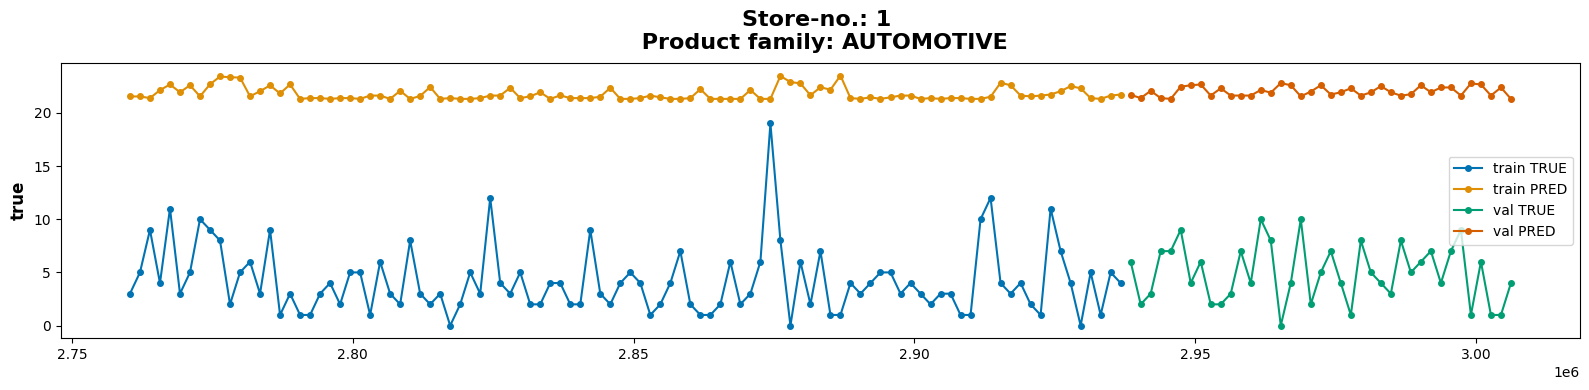

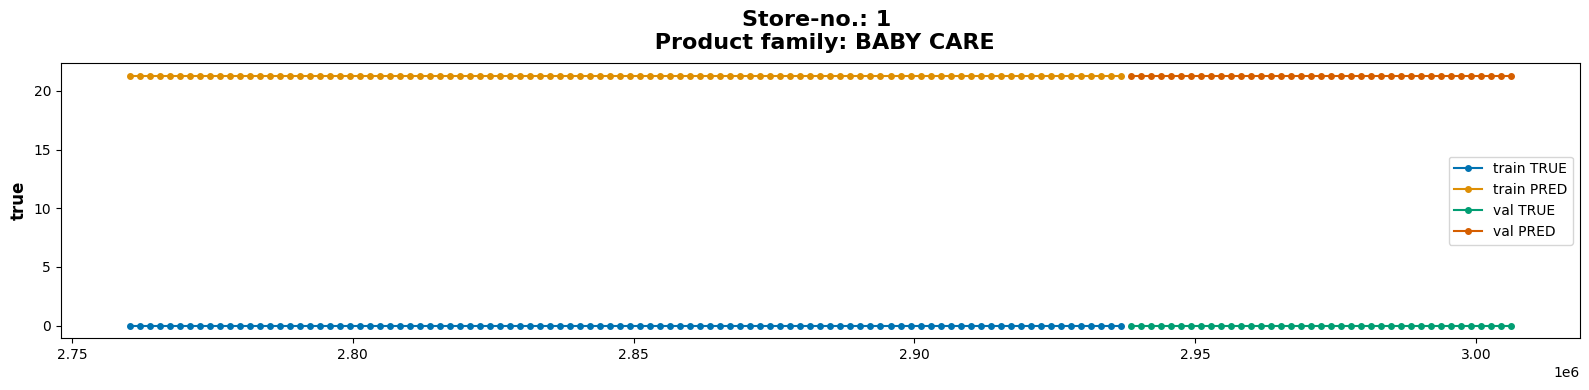

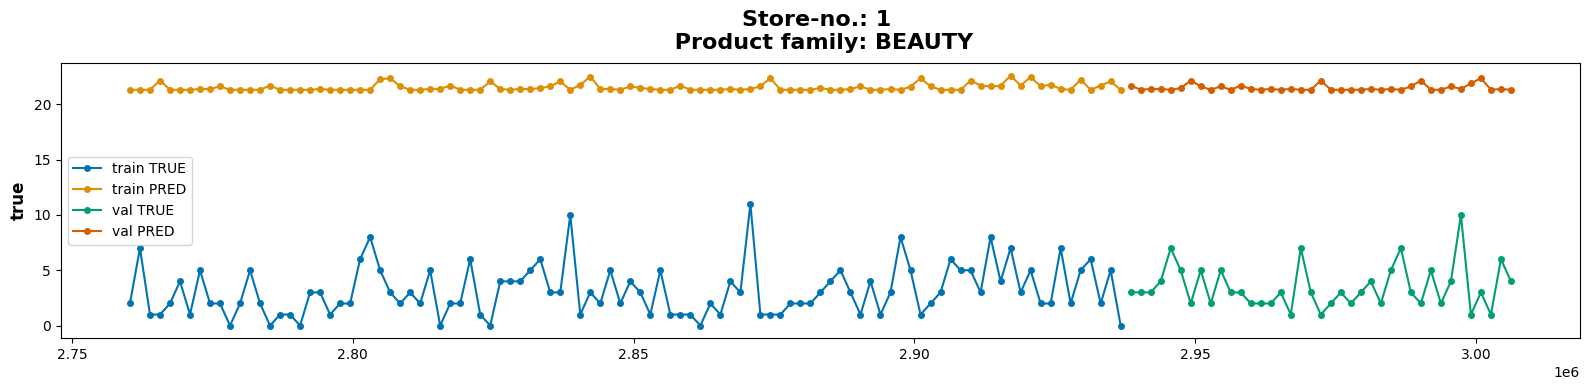

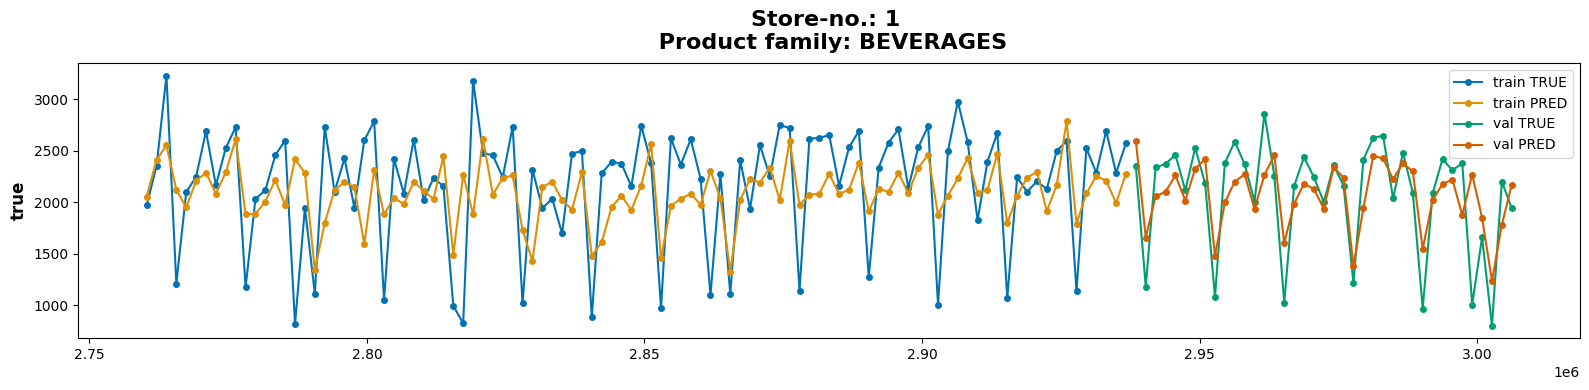

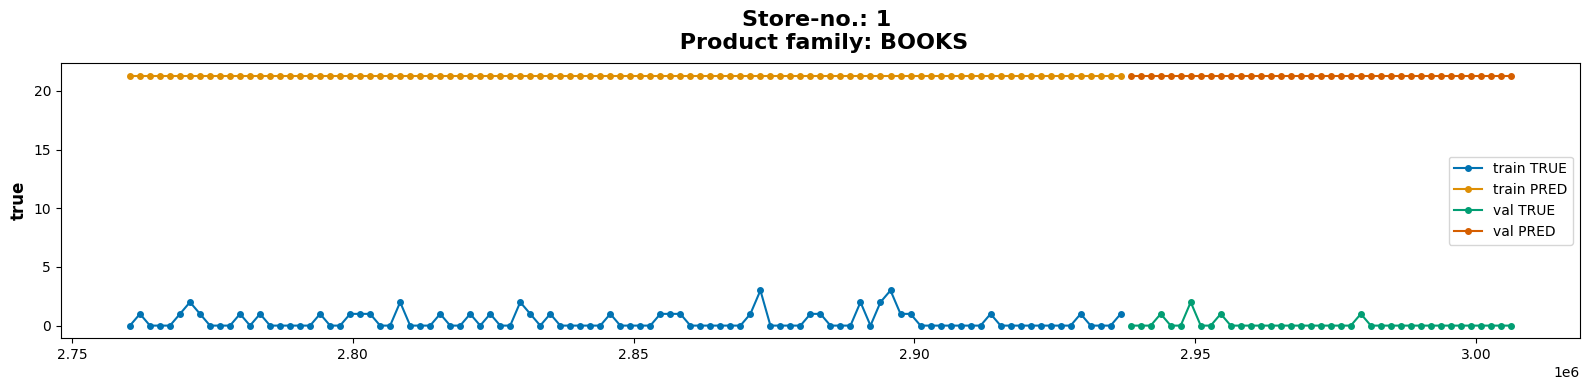

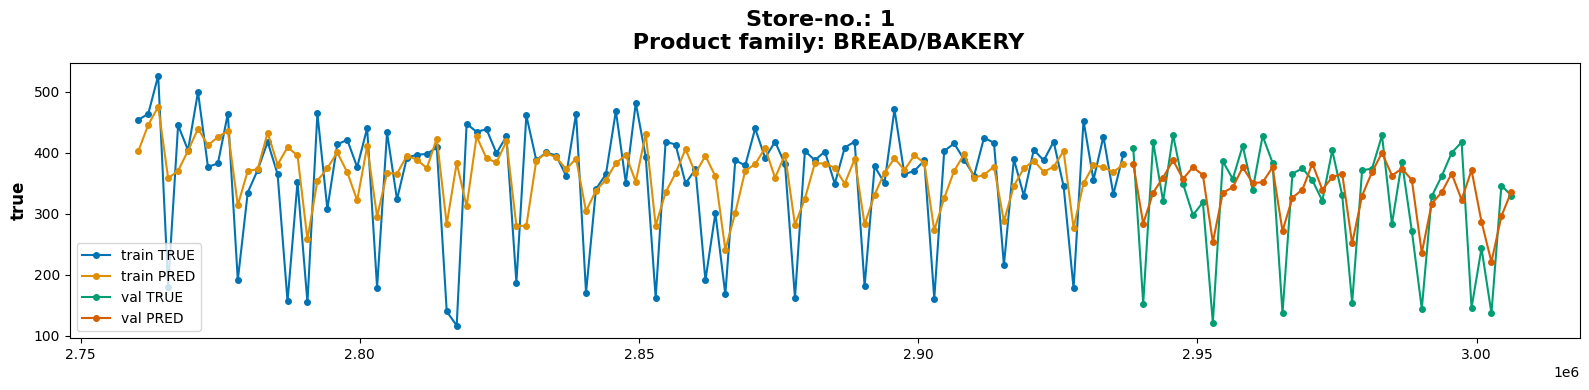

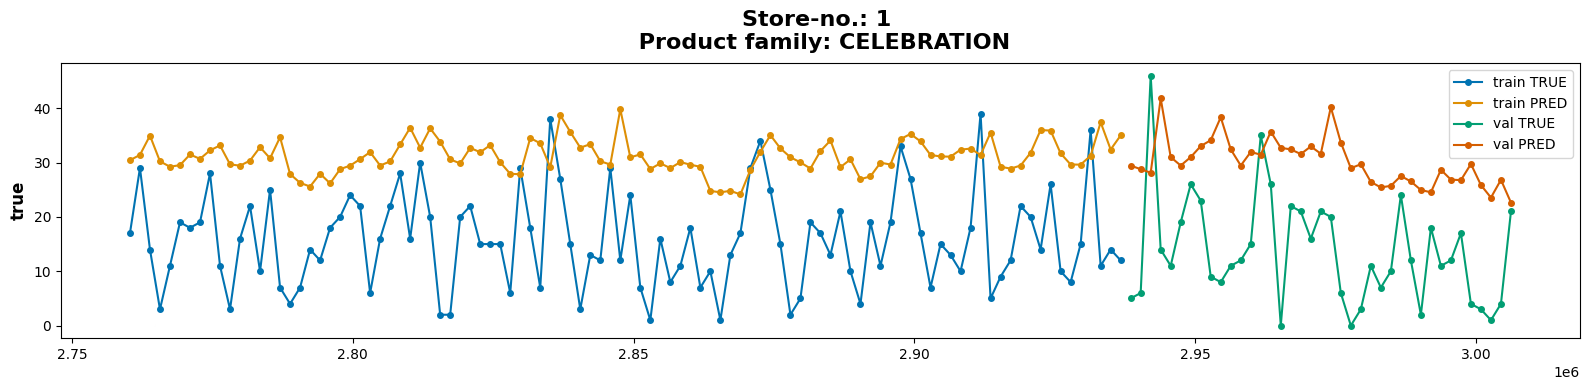

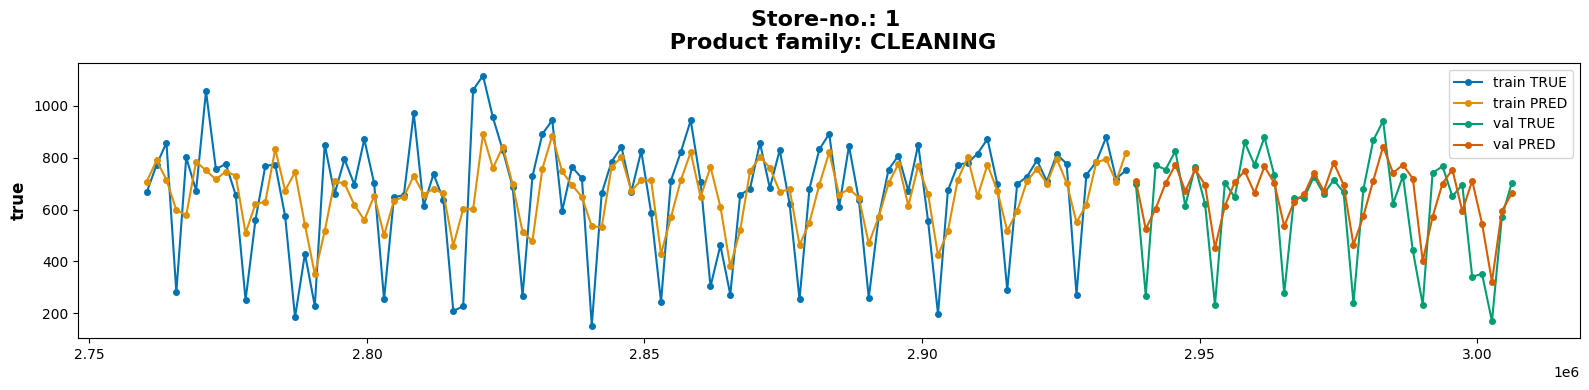

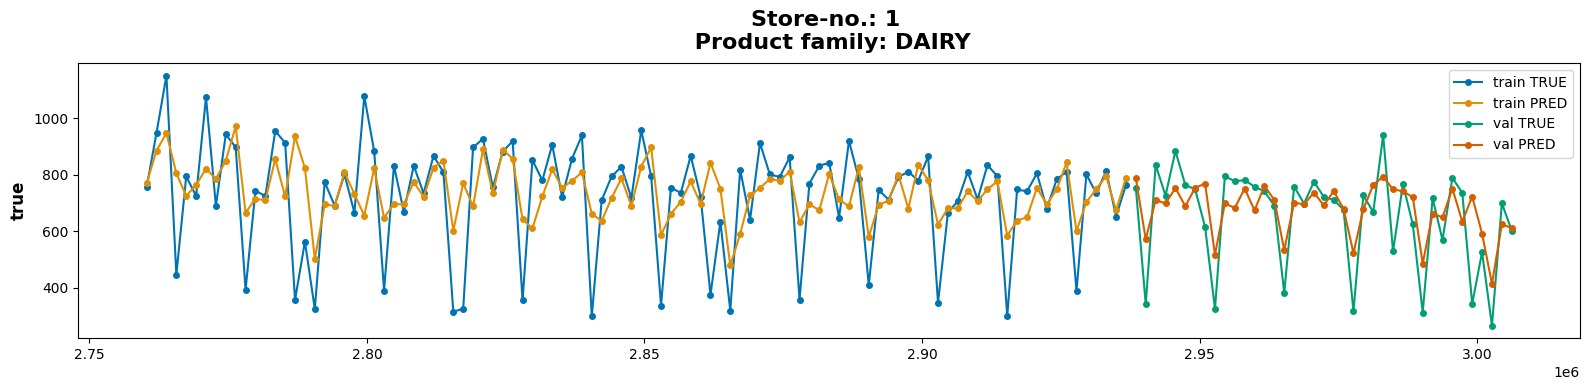

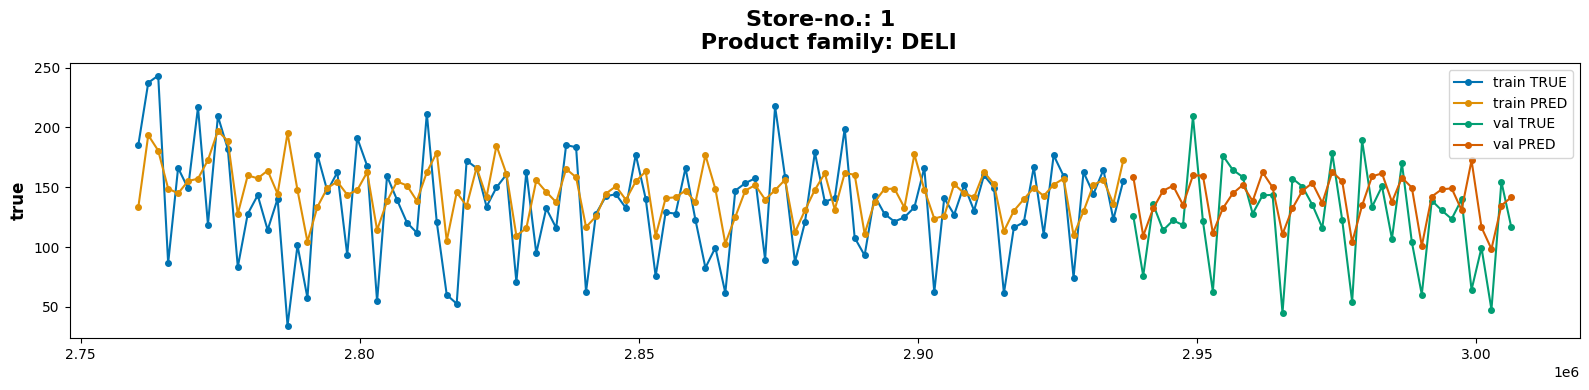

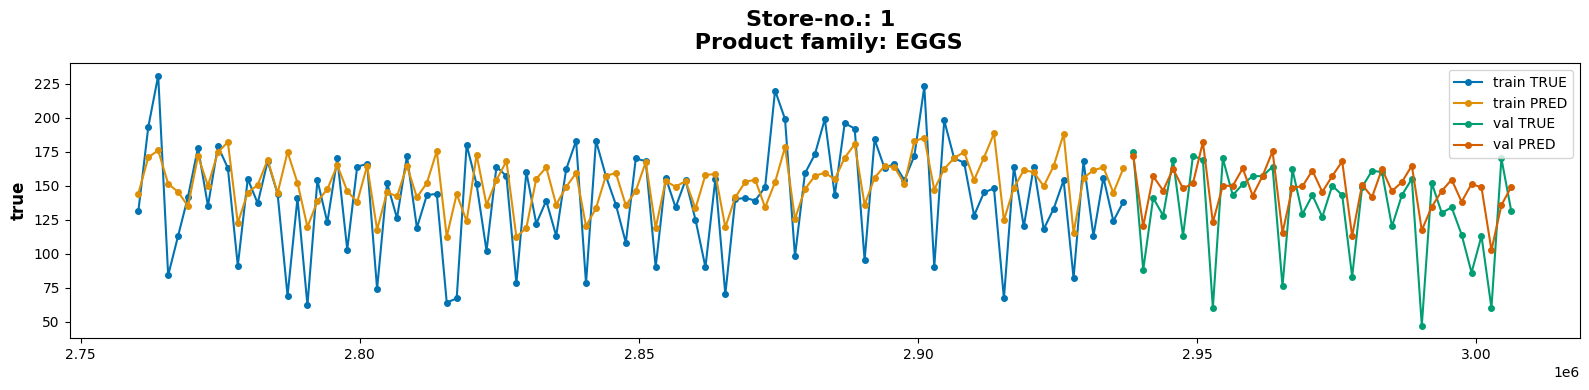

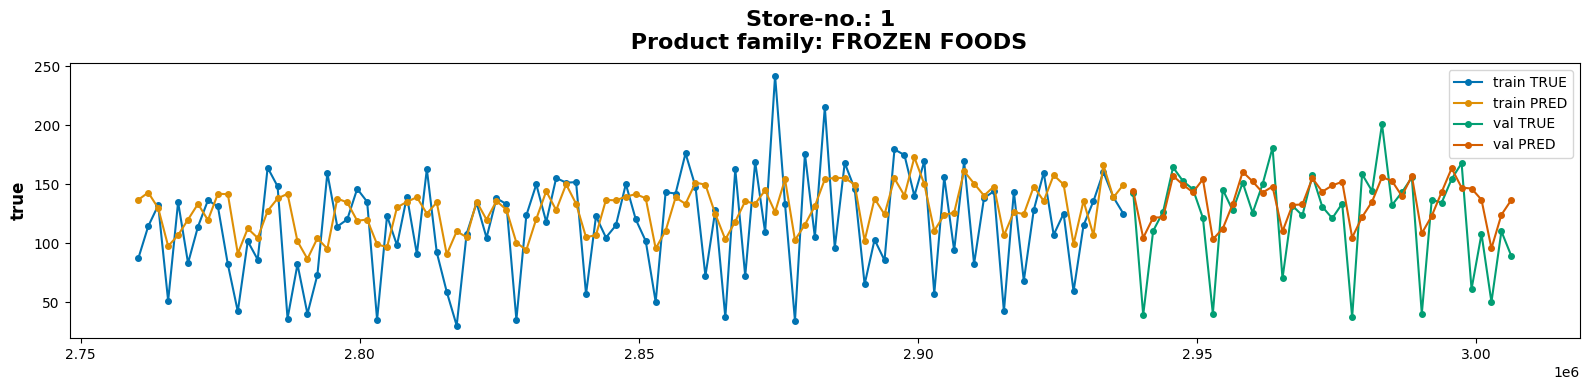

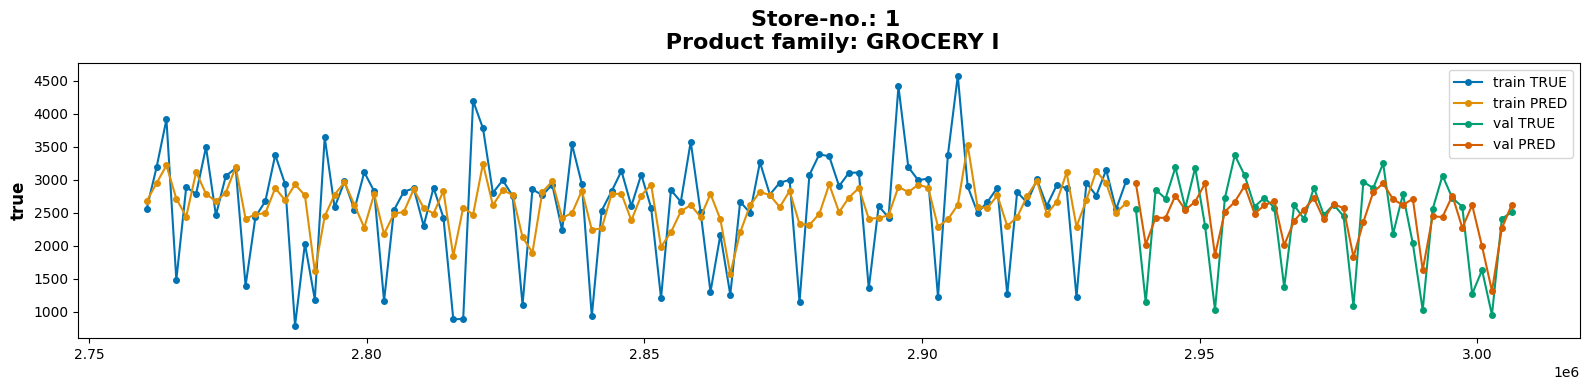

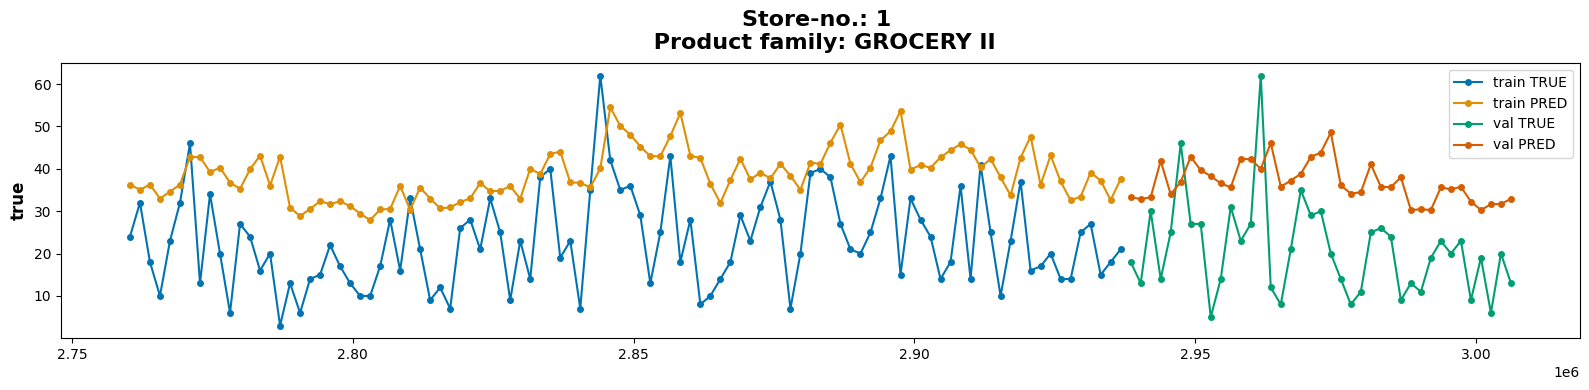

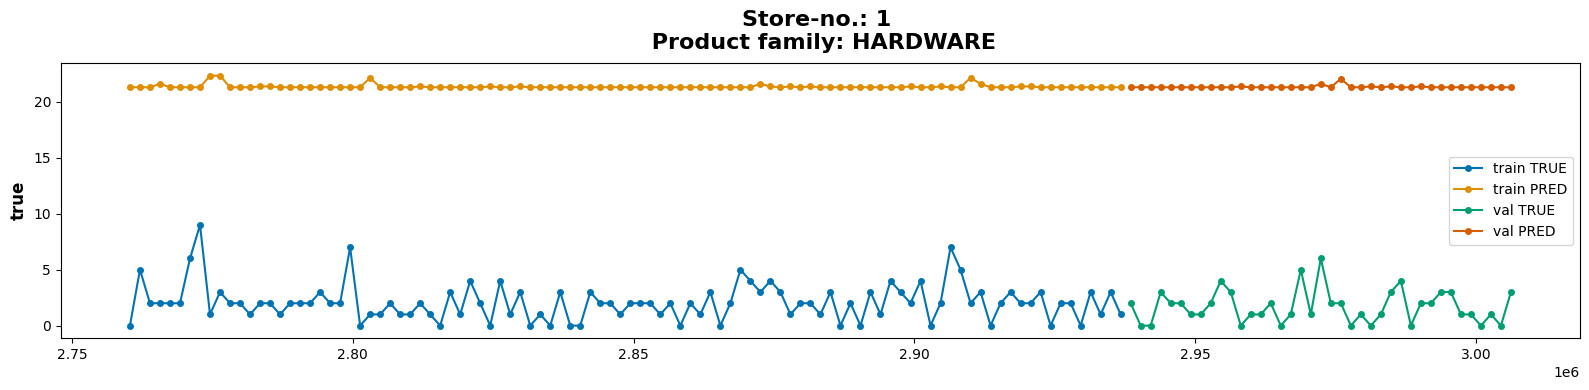

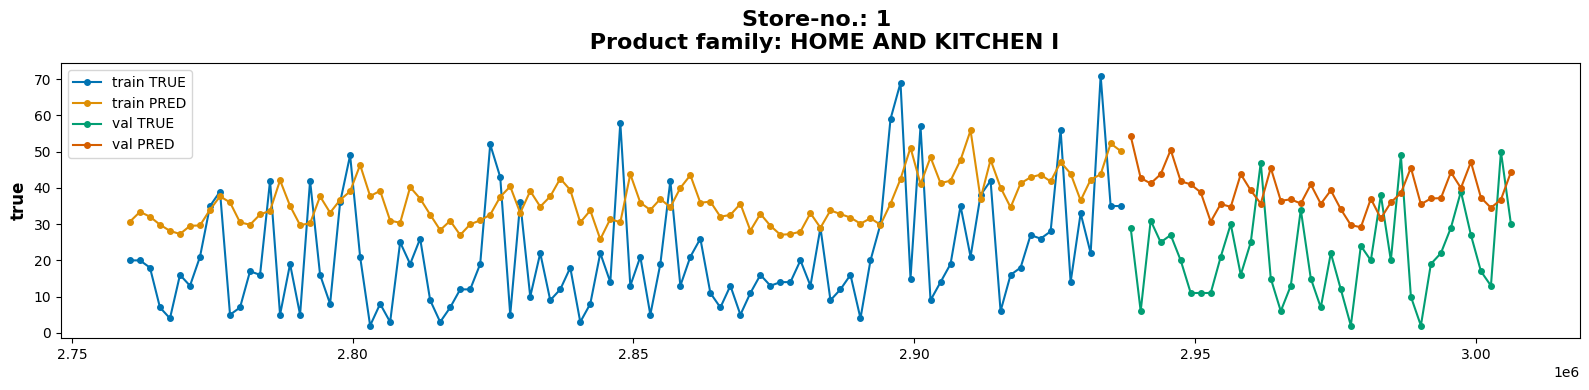

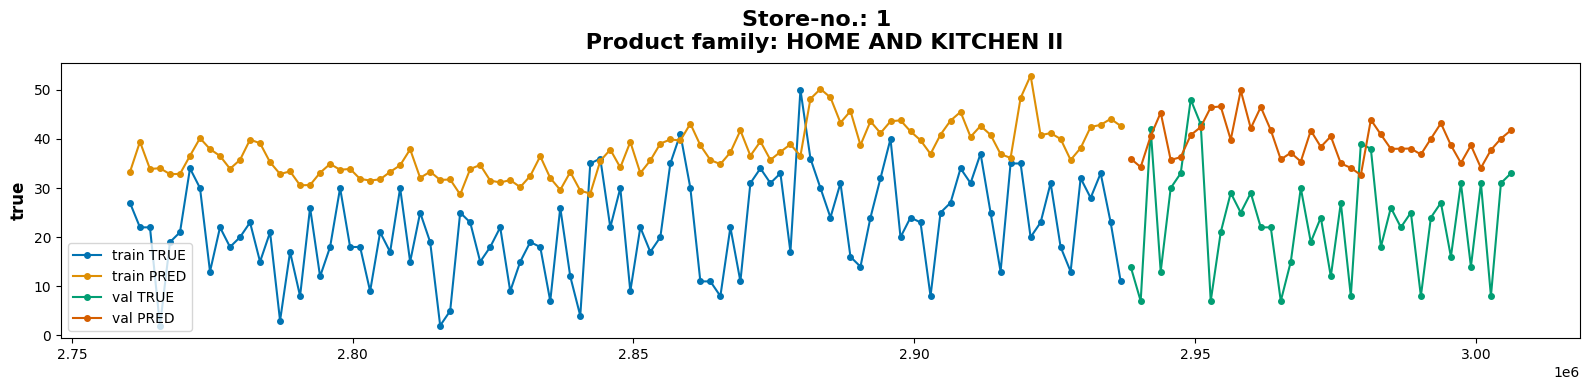

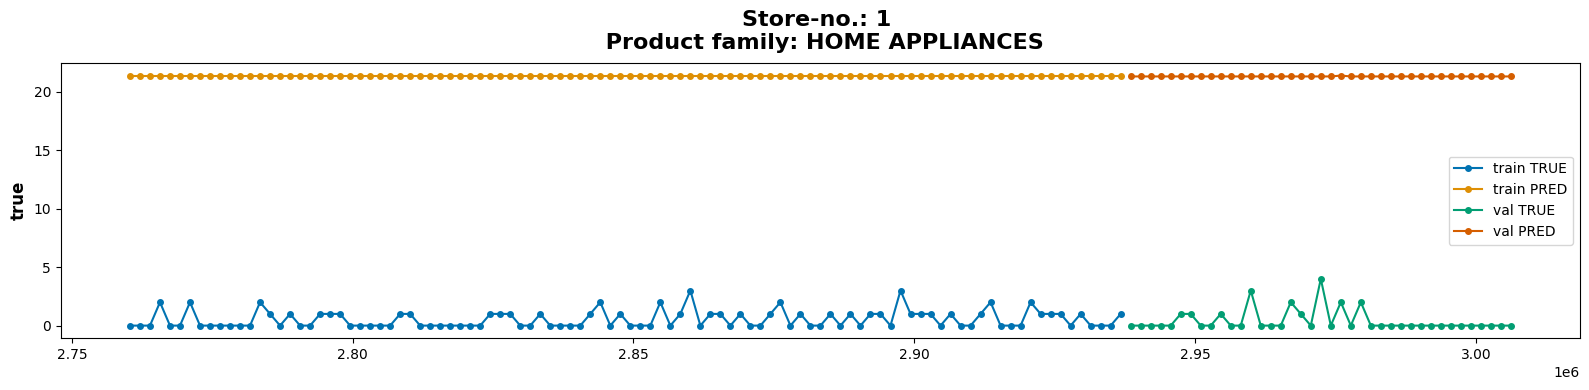

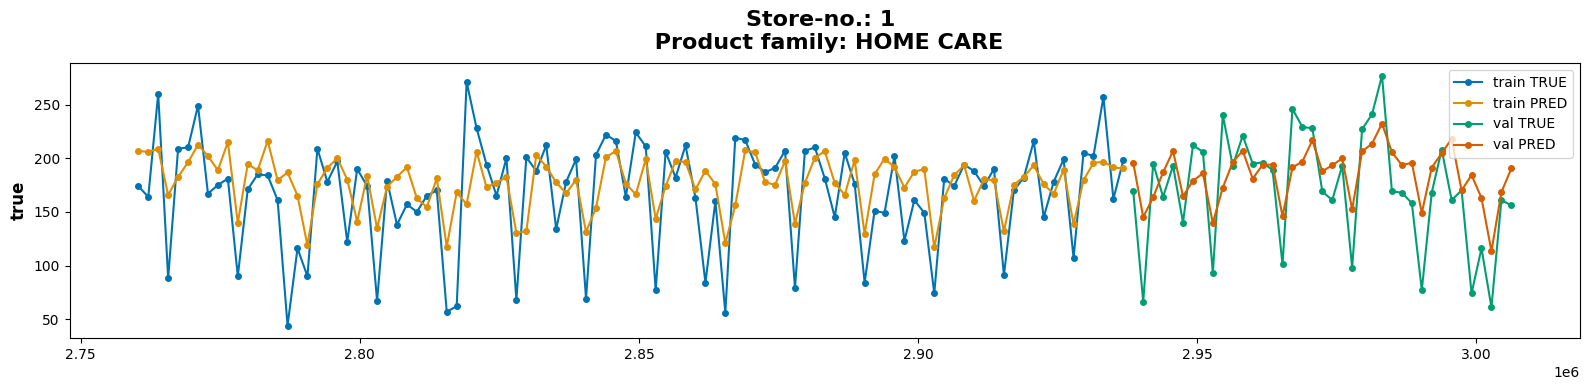

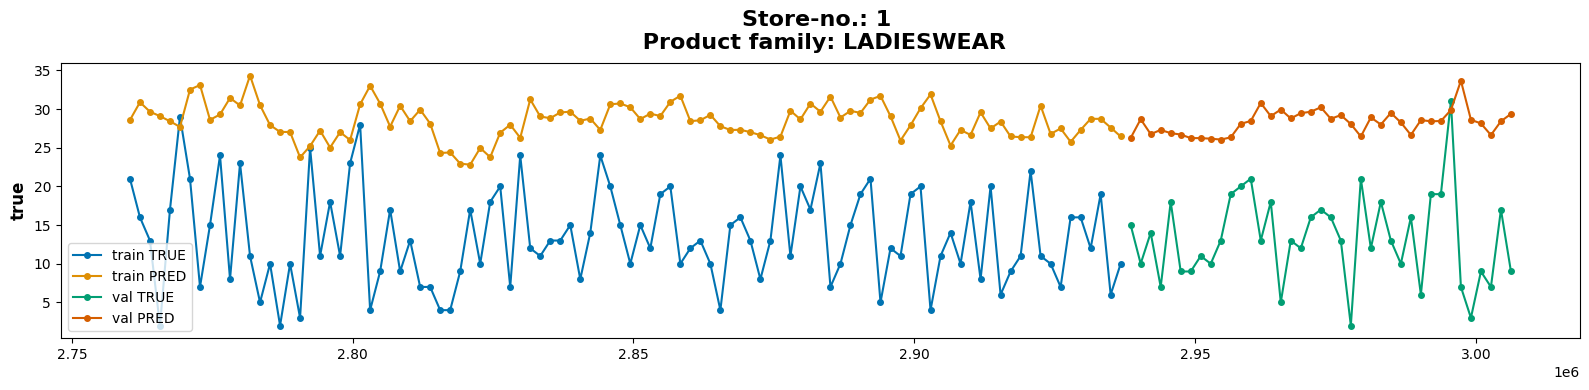

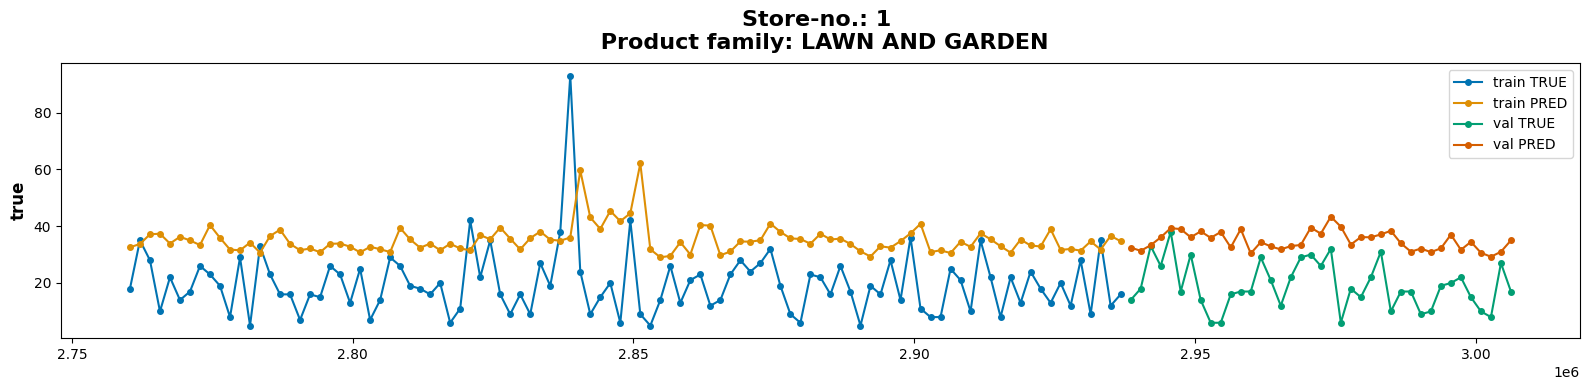

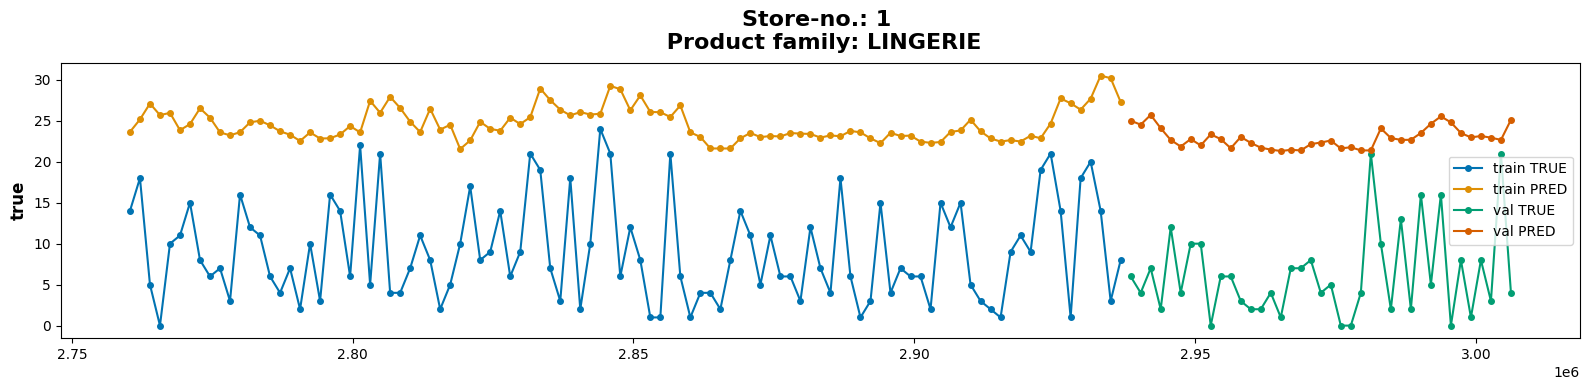

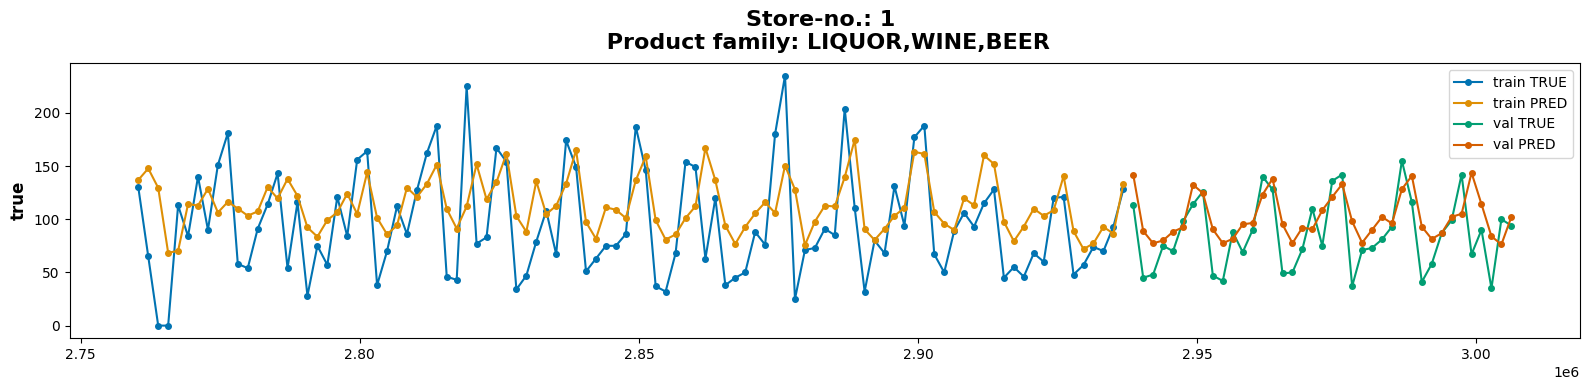

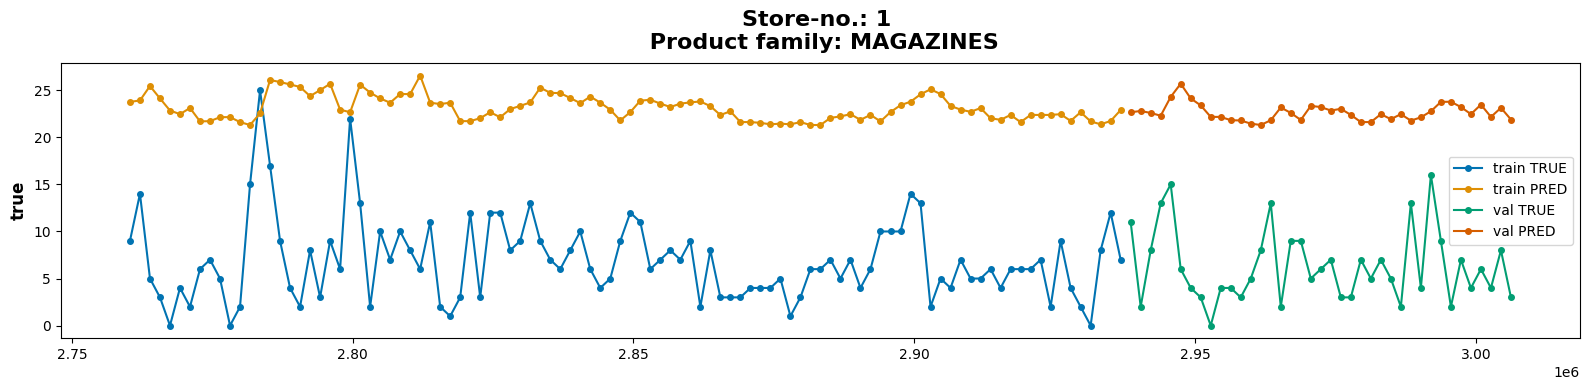

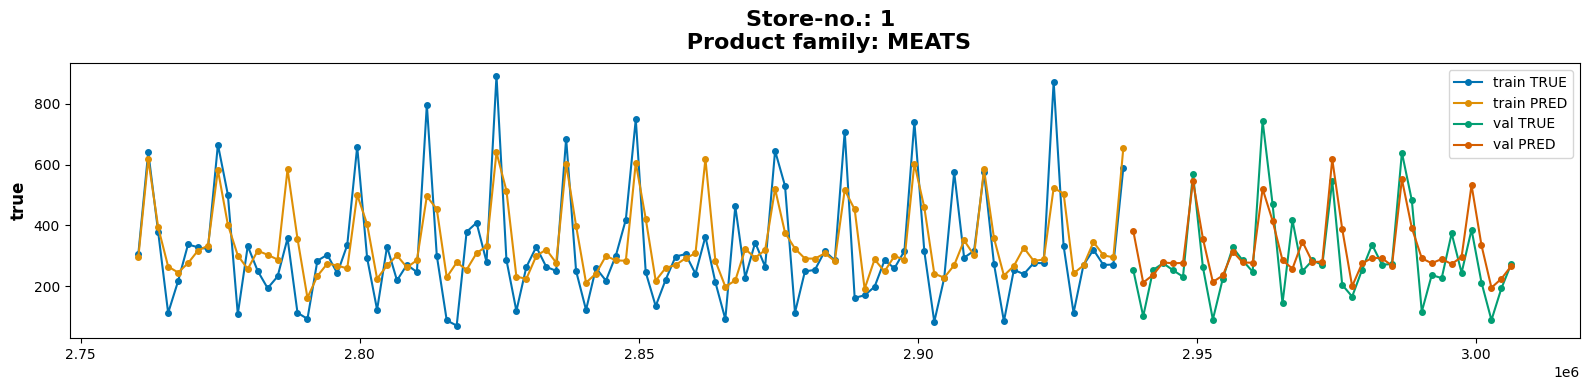

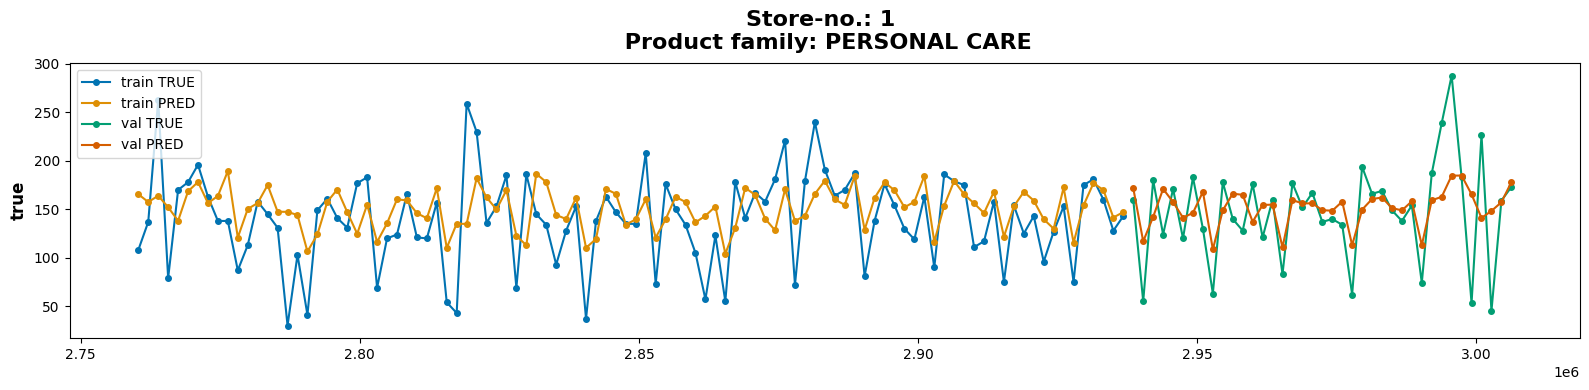

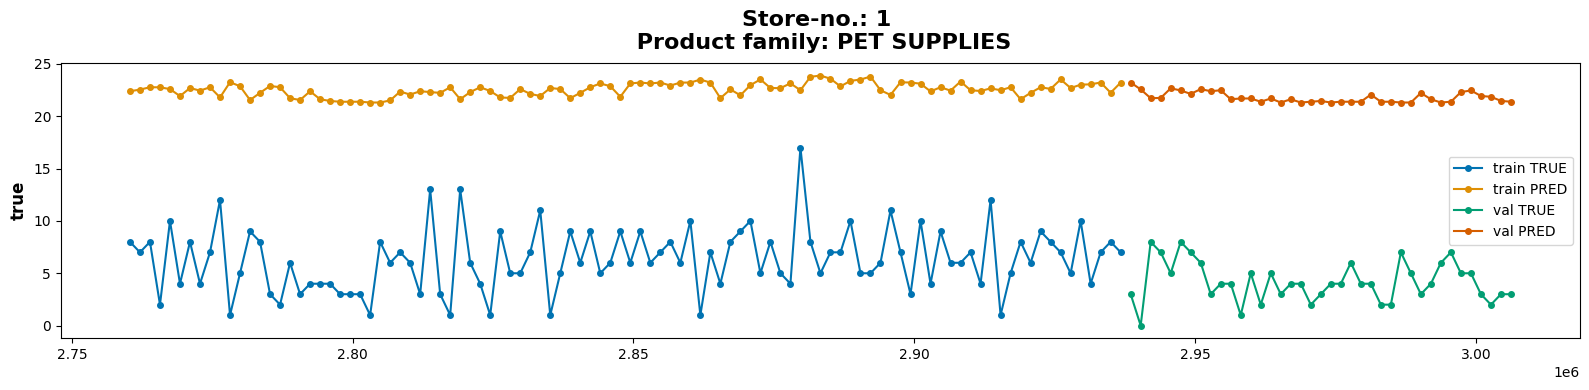

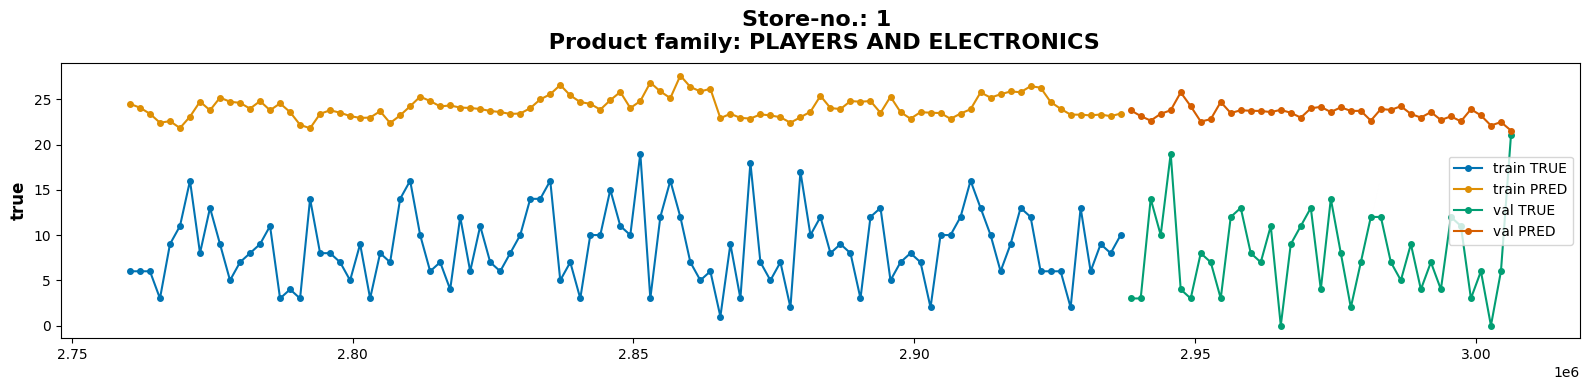

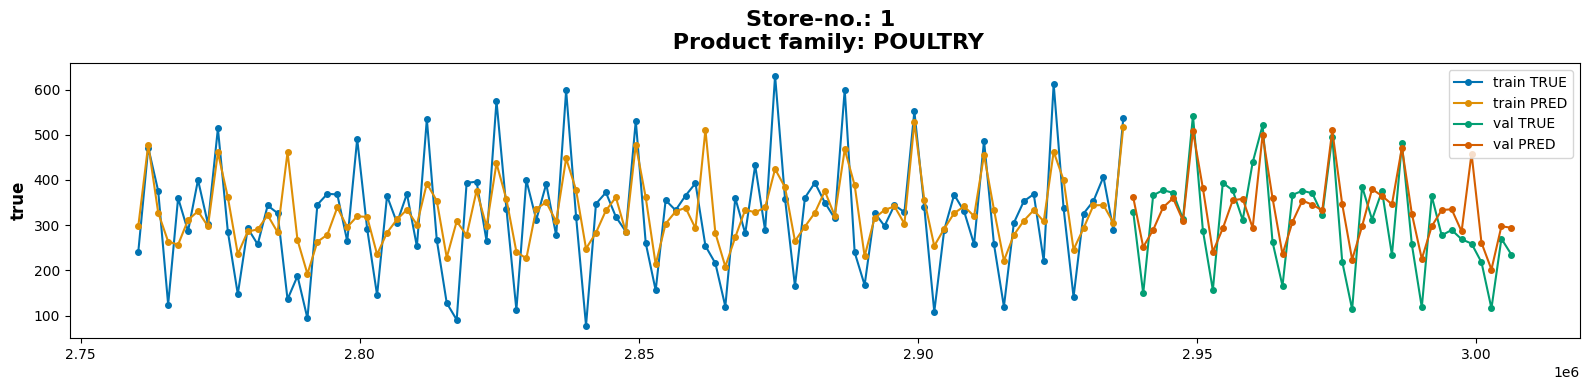

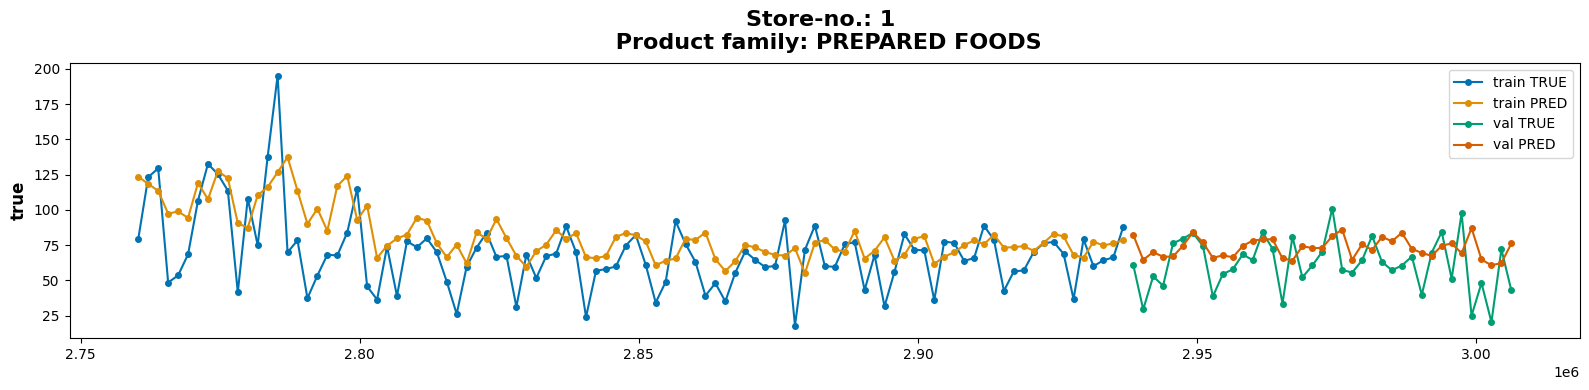

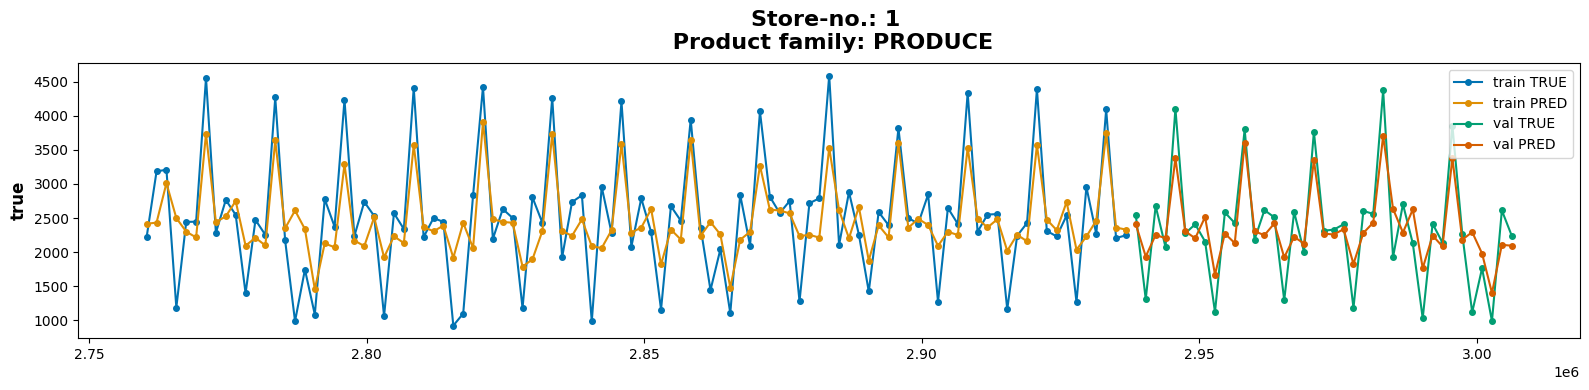

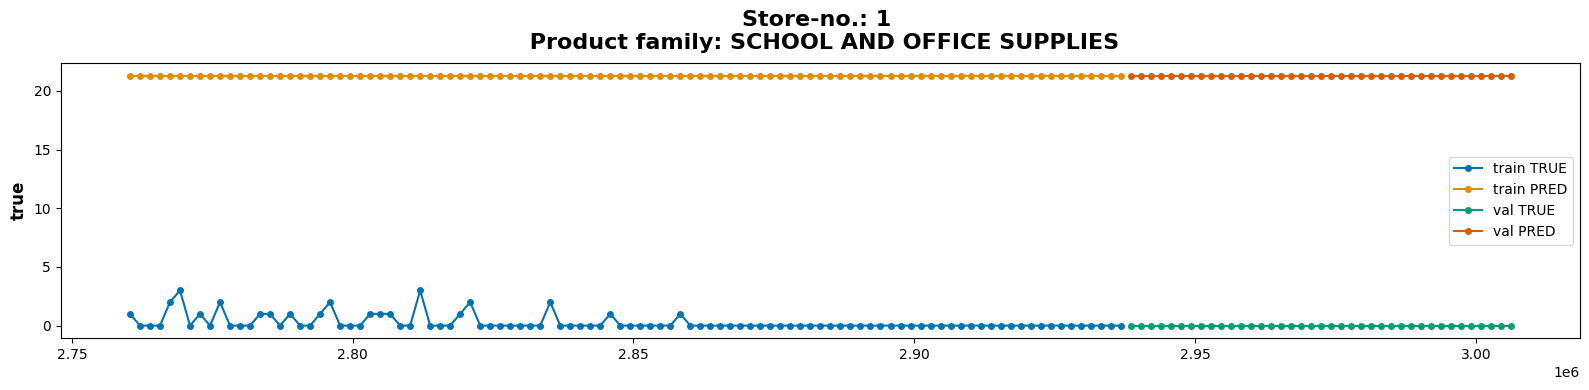

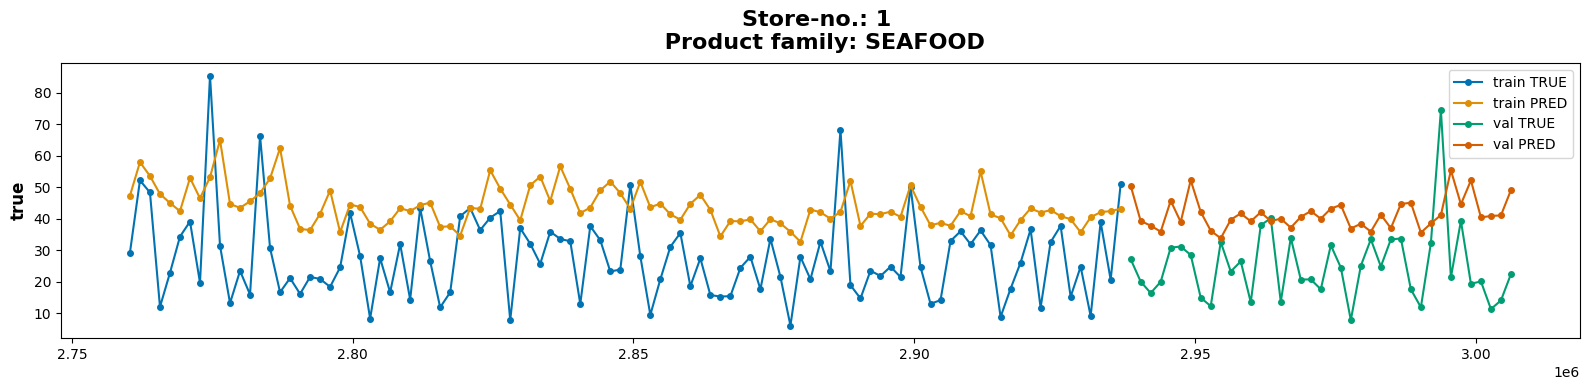

In [151]:
for i in family:
    plot_results(dic_groups, 1, i)